In [1]:
from ActivePyTools.grab_data import eval_object_columns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import cv2
import pandas as pd
import numpy as np
import chardet

crop_path = '../docs/crop_pics/google/'

def grab_df_data(df_path):
    with open(df_path, 'rb') as file:
        encoding = chardet.detect(file.read())['encoding']

    temp_df = pd.read_csv(df_path, encoding=encoding)
    df = eval_object_columns(temp_df)
    return df

def normalize_row(row, img_shape):
    img_height, img_width, _ = img_shape
    text_len = len(row.txt)
    slope1, slope2, slope3, slope4 = row.slopes
    direction = 1 if row.direction == 'vertical' else 0
    if direction:
        slope = (slope1 + slope3) / 2
    else:
        slope = (slope2 + slope4) / 2
    if slope == 0:
        slope = 0.0001
    angle = np.rad2deg(np.arctan2(abs(slope), 1))
    font_h = row.font * np.sin(angle)
    font_w = row.font * np.cos(angle)
    word_len_h = row.word_len * np.sin(90 - angle)
    word_len_w = row.word_len * np.cos(90 - angle)

    font_h /= img_height
    font_w /= img_width
    word_len_h /= img_height
    word_len_w /= img_width

    font = np.sqrt(font_h**2 + font_w**2)
    word_len = np.sqrt(word_len_h**2 + word_len_w**2)

    center_x, center_y = row.center_point
    center_x /= img_width
    center_y /= img_height
    label = row.Label

    return pd.Series({
        'idx': row.idx,
        'txt_len': text_len,
        'direction': direction,
        'angle': angle,
        'norm_font': font,
        'norm_word_len': word_len,
        'norm_center_x': center_x,
        'norm_center_y': center_y,
        'label': label
    })

def sqrt_sq_cbrt_cb(number):
    sign = 1 if number >=0 else -1
    number = abs(number)
    # print(number)
    return sign*np.sqrt(number), np.square(number), sign*np.cbrt(number), sign*np.power(number, 3)

def row_feature_eng(row):
    font_sqrt, font_square, font_cbrt, font_cube = sqrt_sq_cbrt_cb(row.norm_font)
    word_len_sqrt, word_len_square, word_len_cbrt, word_len_cube = sqrt_sq_cbrt_cb(row.txt_len)
    row['font_sqrt'] = font_sqrt
    row['font_square'] = font_square
    row['font_cbrt'] = font_cbrt
    row['font_cube'] = font_cube
    row['word_len_sqrt'] = word_len_sqrt
    row['word_len_square'] = word_len_square
    row['word_len_cbrt'] = word_len_cbrt
    row['word_len_cube'] = word_len_cube
    return row

def normalize_df(df):

    norm_data = []

    for index, row in df.iterrows():
        img_path = row.img_path
        img = cv2.imread(img_path)
        if img is not None:
            new_row = normalize_row(row, img.shape)
            norm_data.append(new_row)

    return pd.DataFrame(norm_data, columns=['idx', 'txt_len', 'direction', 'angle', 'norm_font', 'norm_word_len', 'norm_center_x', 'norm_center_y', 'label'])

def text_to_vector(text, model):
    # Tokenize the text
    words = text.split()
    # Filter words to make sure they are in the model
    words = [word for word in words if word in model.key_to_index]

    # If no words in the model, return a zero vector
    if len(words) == 0:
        return np.zeros(model.vector_size)

    # Compute average vector
    word_vectors = np.array([model[word] for word in words])
    average_vector = word_vectors.mean(axis=0)
    return average_vector

## Combine Dataframes

In [2]:
df_path1 = '../data/Bookshelves_1_df.csv'
df1 = grab_df_data(df_path1)
df1['img_path'] = df1['crop_idx'].apply(lambda x: f"{crop_path}Bookshelves_1.jpg_{x[0]}_{x[1]}.jpg")
df1['idx'] = df1.index

df_path2 = '../data/Bookshelves_4_df.csv'
df2 = grab_df_data(df_path2)
df2['img_path'] = df2['crop_idx'].apply(lambda x: f"{crop_path}Bookshelves_4.jpg_{x[0]}_{x[1]}.jpg")
df2['idx'] = df1['idx'].max() + df2.index

df_path3 = '../data/IMG_7940_labelled_df.csv'
df3 = grab_df_data(df_path3)
df3['img_path'] = df3['crop_idx'].apply(lambda x: f"{crop_path}IMG_7940.jpeg_{x[0]}_{x[1]}.jpg")
df3['idx'] = df2['idx'].max() + df3.index

In [3]:
df = pd.concat([df1, df2, df3], ignore_index=True)
df = df.drop(columns=['confidence', 'crop_idx', 'Left', 'Top'])
df

,txt,vertices,boundBox,slopes,font,word_len,direction,center_point,Label,img_path,idx
0,THE,"[(83, 360), (85, 402), (69, 403), (67, 361)]","{'Width': 18, 'Height': 43, 'Left': 67, 'Top':...","(-21.0, 0.062, -21.0, 0.062)",16.031220,42.047592,vertical,"(76.0, 381.5)",1,../docs/crop_pics/google/Bookshelves_1.jpg_0_0...,0
1,TIPPING,"[(85, 412), (88, 501), (72, 502), (69, 413)]","{'Width': 19, 'Height': 90, 'Left': 69, 'Top':...","(-29.667, 0.062, -29.667, 0.062)",16.031220,89.050547,vertical,"(78.5, 457.0)",1,../docs/crop_pics/google/Bookshelves_1.jpg_0_0...,1
2,POINT,"[(89, 511), (92, 578), (76, 579), (73, 512)]","{'Width': 19, 'Height': 68, 'Left': 73, 'Top':...","(-22.333, 0.062, -22.333, 0.062)",16.031220,67.067131,vertical,"(82.5, 545.0)",1,../docs/crop_pics/google/Bookshelves_1.jpg_0_0...,2
3,MALCOLM,"[(90, 621), (95, 722), (80, 723), (75, 622)]","{'Width': 20, 'Height': 102, 'Left': 75, 'Top'...","(-20.2, 0.067, -20.2, 0.067)",15.033296,101.123687,vertical,"(85.0, 672.0)",1,../docs/crop_pics/google/Bookshelves_1.jpg_0_0...,3
4,GLADWELL,"[(96, 735), (102, 846), (87, 847), (81, 736)]","{'Width': 21, 'Height': 112, 'Left': 81, 'Top'...","(-18.5, 0.067, -18.5, 0.067)",15.033296,111.162044,vertical,"(91.5, 791.0)",1,../docs/crop_pics/google/Bookshelves_1.jpg_0_0...,4
...,...,...,...,...,...,...,...,...,...,...,...
1415,POETRY,"[(3870, 560), (3858, 639), (3839, 636), (3851,...","{'Width': 31, 'Height': 82, 'Left': 3839, 'Top...","(6.583, -0.158, 6.583, -0.158)",19.235384,79.906195,vertical,"(3854.5, 598.0)",1,../docs/crop_pics/google/IMG_7940.jpeg_0_0.jpg,1413
1416,OF,"[(3877, 517), (3873, 544), (3853, 541), (3857,...","{'Width': 24, 'Height': 30, 'Left': 3853, 'Top...","(6.75, -0.15, 6.75, -0.15)",20.223748,27.294688,vertical,"(3865.0, 529.0)",1,../docs/crop_pics/google/IMG_7940.jpeg_0_0.jpg,1414
1417,BOOK,"[(3887, 451), (3879, 504), (3860, 502), (3868,...","{'Width': 27, 'Height': 56, 'Left': 3860, 'Top...","(6.625, -0.105, 6.75, -0.158)",19.170179,54.094875,vertical,"(3873.5, 476.25)",1,../docs/crop_pics/google/IMG_7940.jpeg_0_0.jpg,1415
1418,THE,"[(3896, 395), (3890, 436), (3870, 433), (3876,...","{'Width': 26, 'Height': 44, 'Left': 3870, 'Top...","(6.833, -0.15, 6.833, -0.15)",20.223748,41.436699,vertical,"(3883.0, 414.0)",1,../docs/crop_pics/google/IMG_7940.jpeg_0_0.jpg,1416


## Prepare Train, Validation, Test Data

In [4]:
one_df = df[df['Label'] == 1]
zero_df = df[df['Label'] == 0]

In [5]:
from sklearn.model_selection import train_test_split

train_one_df, temp_one_df = train_test_split(one_df, test_size=0.4, random_state=42)
valid_one_df, test_one_df = train_test_split(temp_one_df, test_size=0.5, random_state=42)
train_zero_df, temp_zero_df = train_test_split(zero_df, test_size=0.4, random_state=42)
valid_zero_df, test_zero_df = train_test_split(temp_zero_df, test_size=0.5, random_state=42)

In [6]:
rate = train_one_df.shape[0]/train_zero_df.shape[0]
df_duplicated = train_zero_df.copy()
for i in range(int(rate)-1):
    df_duplicated = pd.concat([train_zero_df, df_duplicated], ignore_index=True)

selected_rows = train_zero_df.sample(frac=rate % 1, random_state=42)
resample_train_zero_df = pd.concat([df_duplicated, selected_rows], ignore_index=True)

In [7]:
valid_concatenated = pd.concat([valid_one_df, valid_zero_df], ignore_index=True)
valid_df = valid_concatenated.sample(frac=1, random_state=42).reset_index(drop=True)
valid_df['type'] = 'valid'

test_concatenated = pd.concat([test_one_df, test_zero_df], ignore_index=True)
test_df = test_concatenated.sample(frac=1, random_state=42).reset_index(drop=True)
test_df['type'] = 'test'

train_concatenated = pd.concat([train_one_df, resample_train_zero_df], ignore_index=True)
train_df = train_concatenated.sample(frac=1, random_state=42).reset_index(drop=True)
train_df['type'] = 'train'

In [8]:
loc_df = pd.concat([train_df, test_df, valid_df], ignore_index=True)
loc_df.to_csv("../data/split_df.csv", index=False, encoding='utf-8')

## Prepare Location Normalized Data

In [9]:
def preprocess_df(df, scaler):
    norm_df = normalize_df(df)
    norm_df['type'] = df['type']
    norm_df['label'] = norm_df['label'].astype(int)
    norm_df['idx'] = norm_df['idx'].astype(int)
    norm_df['txt_len'] = scaler.fit_transform(norm_df[['txt_len']])
    norm_df = norm_df.apply(row_feature_eng, axis=1)

    return norm_df

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))

norm_loc_train_df = preprocess_df(train_df, scaler)
norm_loc_test_df = preprocess_df(test_df, scaler)
norm_loc_valid_df = preprocess_df(valid_df, scaler)

In [11]:
loc_df = pd.concat([norm_loc_train_df, norm_loc_test_df, norm_loc_valid_df], ignore_index=True)
loc_df.to_csv("../data/digit_data/loc_df.csv", index=False, encoding='utf-8')

                      idx   txt_len  direction     angle  norm_font  \
idx              1.000000  0.005398  -0.409938 -0.005305  -0.202448   
txt_len          0.005398  1.000000   0.005465  0.013762  -0.060413   
direction       -0.409938  0.005465   1.000000 -0.175400   0.333748   
angle           -0.005305  0.013762  -0.175400  1.000000  -0.127930   
norm_font       -0.202448 -0.060413   0.333748 -0.127930   1.000000   
norm_word_len   -0.178081  0.448698   0.287666 -0.163740   0.579815   
norm_center_x    0.141995 -0.035878  -0.084946 -0.066561  -0.010234   
norm_center_y   -0.004483 -0.089177  -0.245288  0.085593  -0.198649   
label           -0.132959  0.186947   0.545491 -0.023292   0.180366   
font_sqrt       -0.252495 -0.052897   0.373860 -0.142056   0.985100   
font_square     -0.124760 -0.064855   0.252881 -0.089199   0.954224   
font_cbrt       -0.269688 -0.049648   0.385557 -0.145070   0.972863   
font_cube       -0.078984 -0.057345   0.186355 -0.051613   0.842697   
word_l

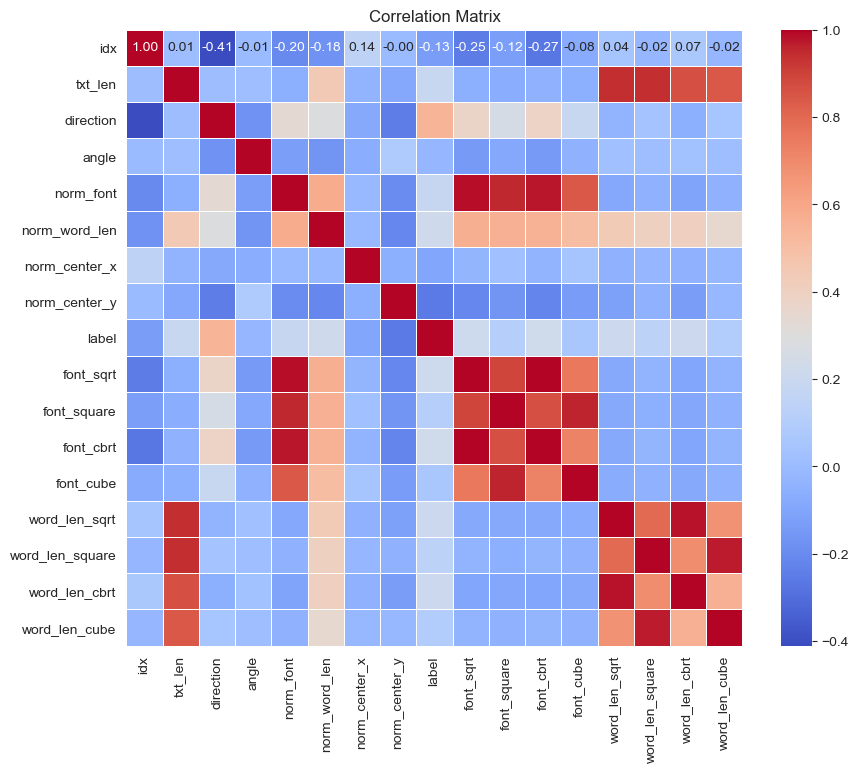

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = loc_df.drop(columns='type').corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)

plt.title('Correlation Matrix')
plt.show()

## Prepare Text Vector Normalized Data

In [13]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True)

In [14]:
def calc_text_vector(df):
    vector_df = pd.DataFrame()
    vector_df['type'] = df['type']
    vector_df['txt_vector'] = df['txt'].apply(lambda x: text_to_vector(x, model))
    vector_df['label'] = df['Label']
    vector_df['idx'] = df['idx']
    vectors = pd.DataFrame(vector_df['txt_vector'].tolist(), index=vector_df.index)
    vectors.columns = [f'vector_{i}' for i in range(vectors.shape[1])]
    vector_lst_df = pd.concat([vector_df.drop('txt_vector', axis=1), vectors], axis=1)
    
    return vector_lst_df

In [15]:
norm_vec_train_df = calc_text_vector(train_df)
norm_vec_test_df = calc_text_vector(test_df)
norm_vec_valid_df = calc_text_vector(valid_df)

In [16]:
vec_df = pd.concat([norm_vec_train_df, norm_vec_test_df, norm_vec_valid_df], ignore_index=True)
vec_df.to_csv("../data/digit_data/vec_df.csv", index=False, encoding='utf-8')